In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

import torch as pt
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision import transforms

import albumentations as A
import os

%matplotlib inline

In [2]:
def set_seed(seed):
    pt.manual_seed(seed)
    pt.cuda.manual_seed(seed)
    pt.cuda.manual_seed_all(seed)
    np.random.seed(seed)
set_seed(42)

In [3]:
def get_albumentation_transforms(p=0.5):
    return A.Compose([
        A.Resize(150, 150),
        A.RandomBrightnessContrast(brightness_by_max=0.1, contrast_limit=0.05, p=0.5),
        A.Rotate(limit=20, p=0.5),
        A.RandomRain(p=0.5),
        A.OneOf([
            A.RandomFog(fog_coef_lower=0.05, fog_coef_upper=0.1, alpha_coef=0, p=0.2),
            A.RandomSnow(snow_point_lower=0.05, snow_point_upper=0.1, brightness_coeff=0.5, p=0.2),
        ], p=0.4),
        A.GaussNoise(p=0.3),
        A.HueSaturationValue(p=0.3),
        A.HorizontalFlip(p=0.5),
        A.ToGray(p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.Sharpen(),
        ], p=0.3),
        A.OneOf([
            A.RGBShift(r_shift_limit=5, g_shift_limit=5, b_shift_limit=5, p=0.4),
            A.ChannelShuffle(p=0.4),
        ], p=0.3),
    ], p=p)

In [4]:
def augment(aug, image):
    return aug(image=image)["image"]

In [5]:
class AlbumentationsTransforms(object):
    def __call__(self, img):
        aug = get_albumentation_transforms(p=1.0)
        return Image.fromarray(augment(aug, np.array(img)))

In [6]:
data_transforms = {
    "train_transforms": transforms.Compose([
        AlbumentationsTransforms(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.3821, 0.3963, 0.3945),
            std=(0.1891, 0.1900, 0.1938),
        ),
    ]),
    "test_transforms": transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.4332, 0.4586, 0.4552),
            std=(0.2206, 0.2191, 0.2285),
        ),
    ]),
    "valid_transforms": transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.4335, 0.4599, 0.4543),
            std=(0.2203, 0.2193, 0.2278),
        ),
    ]),
}

In [7]:
trainset = datasets.ImageFolder("./data/train", transform=data_transforms["train_transforms"])
testset = datasets.ImageFolder("./data/test", transform=data_transforms["test_transforms"])

In [8]:
CLASSES = trainset.classes
batch_size = 32
device = "cuda" if pt.cuda.is_available() else "cpu"

In [9]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [10]:
print (f"Total number of samples found in Train Set are: {len(trainloader.dataset)}")
print (f"Total number of samples found in Test Set are: {len(testloader.dataset)}")

Total number of samples found in Train Set are: 14034
Total number of samples found in Test Set are: 3000


In [11]:
n_samples_per_class = {
    "mountain": 0, "buildings": 0, "glacier": 0,
    "forest": 0, "street": 0, "sea": 0,
}

In [12]:
for _, labels in trainloader:
    for label in labels:
        n_samples_per_class[CLASSES[label.item()]] += 1

<BarContainer object of 6 artists>

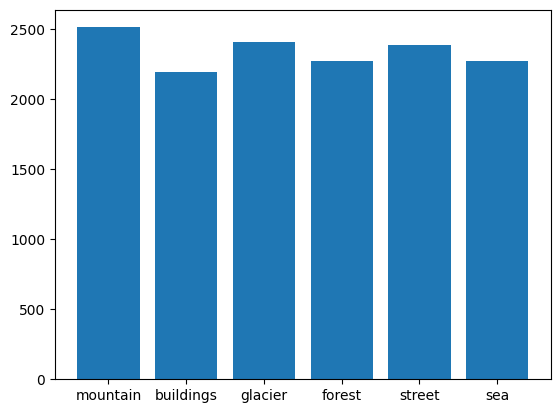

In [13]:
plt.bar(n_samples_per_class.keys(), n_samples_per_class.values())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

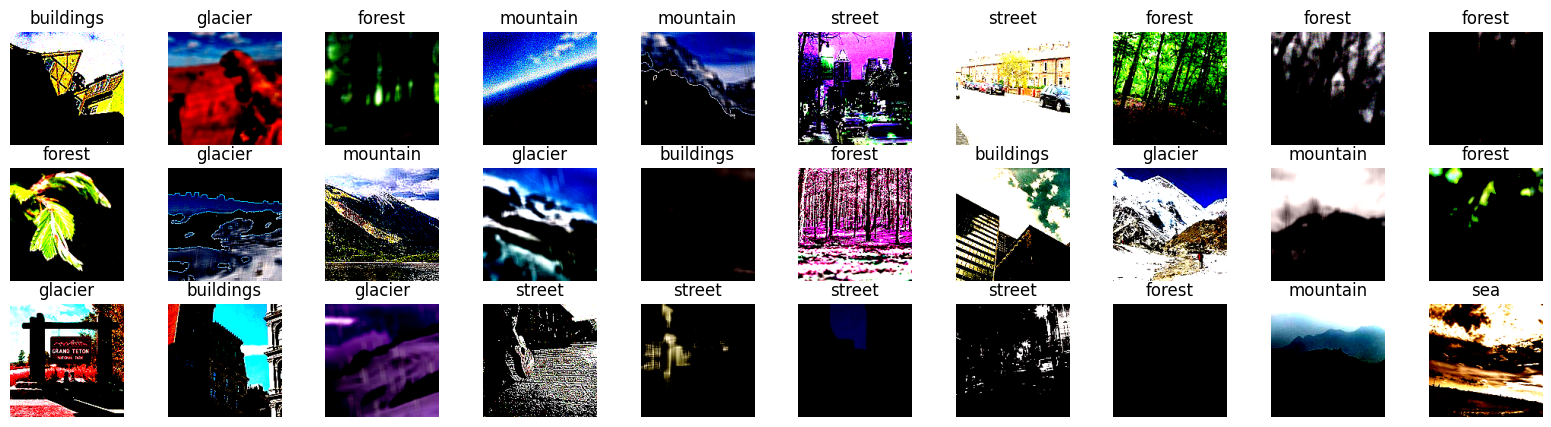

In [14]:
plt.figure(figsize=(20, 5), dpi=100)

images, labels = next(iter(trainloader))
for idx in range(30):
    plt.subplot(3, 10, idx+1)
    plt.imshow(images[idx].numpy().transpose(1, 2, 0))
    plt.axis("off")
    plt.title(CLASSES[labels[idx].item()])

In [15]:
def criterion(pred, labels, reduction="mean"):
    return F.nll_loss(pred, labels, reduction=reduction)

In [16]:
dropout_rate = 0.0

In [17]:
model = models.mobilenet_v2(pretrained=True)
model.classifier[1].out_features = len(CLASSES)

In [18]:
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

In [19]:
def train(e):
    model.train(mode=True)
    train_loss = 0
    train_accuracy = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        pred = F.log_softmax(model(images), dim=1)
        loss = criterion(pred, labels)
        pred = pred.data.max(1, keepdim=True)[1]
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_accuracy += pred.eq(labels.view_as(pred)).sum().item()
    train_loss /= len(trainloader.dataset)
    train_accuracy /= len(trainloader.dataset)
    print (f"Epoch: {e+1}/{epochs} Training loss: {loss.item():.6f} Training Accuracy: {train_accuracy:.6f}", end="; ")
    return train_loss, train_accuracy

def validation_step():
    model.eval()
    test_loss = 0
    test_acc = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        pred = F.log_softmax(model(images), dim=1)
        test_loss += criterion(pred, labels, reduction="sum").item() * images.size(0)
        pred = pred.data.max(1, keepdim=True)[1]
        test_acc += pred.eq(labels.view_as(pred)).sum().item()
    test_loss /= len(testloader.dataset)
    test_acc /= len(testloader.dataset)
    print (f"Validation loss: {test_loss:.6f} Validation Accuracy: {test_acc:.6f}")
    return test_loss, test_acc

def predict(loader):
    model.eval()
    pred = list()
    for images, _ in loader:
        images = images.to(device)
        output = F.log_softmax(model(images), dim=1)
        pred.append((output.data.max(1, keepdim=True)[1]).item())
    return pred

In [20]:
class EarlyStop:
    def __init__(self, patience, min_acc) -> None:
        self.patience = patience
        self.min_acc = min_acc
        self.stop = False
        self.counter = 0

    def __call__(self, valid_acc):
        if self.patience <= self.counter:
            self.stop = True
        else:
            if valid_acc > self.min_acc:
                self.counter += 1
            else:
                self.counter = 0

In [21]:
train_loss, train_acc, test_acc, test_loss = list(), list(), list(), list()
stopper = EarlyStop(patience=3, min_acc=93.0)
for i in range(epochs):
    if stopper.stop:
        print ("Stopping early")
        break
    tmp_train_loss, tmp_train_acc = train(i)
    train_loss.append(tmp_train_loss), train_acc.append(tmp_train_acc)
    tmp_test_loss, tmp_test_acc = validation_step()
    test_loss.append(tmp_test_loss), test_acc.append(tmp_test_acc)
    stopper(tmp_test_acc)

Epoch: 1/10 Training loss: 0.626757 Training Accuracy: 0.750534; Validation loss: 9.767038 Validation Accuracy: 0.895333
Epoch: 2/10 Training loss: 0.759769 Training Accuracy: 0.814807; Validation loss: 9.044350 Validation Accuracy: 0.895000
Epoch: 3/10 Training loss: 0.398875 Training Accuracy: 0.831338; Validation loss: 9.270640 Validation Accuracy: 0.905333
Epoch: 4/10 Training loss: 0.729851 Training Accuracy: 0.842169; Validation loss: 9.526371 Validation Accuracy: 0.896000
Epoch: 5/10 Training loss: 0.440591 Training Accuracy: 0.849580; Validation loss: 10.399885 Validation Accuracy: 0.892333
Epoch: 6/10 Training loss: 0.411707 Training Accuracy: 0.843095; Validation loss: 8.540928 Validation Accuracy: 0.909000
Epoch: 7/10 Training loss: 0.581377 Training Accuracy: 0.852644; Validation loss: 9.334509 Validation Accuracy: 0.892333
Epoch: 8/10 Training loss: 0.685383 Training Accuracy: 0.852359; Validation loss: 9.514273 Validation Accuracy: 0.894000
Epoch: 9/10 Training loss: 0.70

Text(0.5, 1.0, 'Test Accuracy')

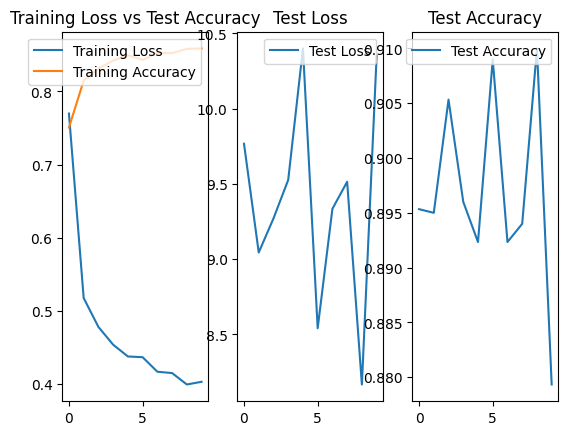

In [23]:
plt.subplot(1, 3, 1)
plt.plot(train_loss, label="Training Loss")
plt.plot(train_acc, label="Training Accuracy")
plt.legend(loc="upper right")
plt.title("Training Loss vs Test Accuracy")
plt.subplot(1, 3, 2)
plt.plot(test_loss, label="Test Loss")
plt.legend(loc="upper right")
plt.title("Test Loss")
plt.subplot(1, 3, 3)
plt.plot(test_acc, label="Test Accuracy")
plt.legend(loc="upper right")
plt.title("Test Accuracy")

In [24]:
validation_imagenames = []

In [25]:
def validset_loader(image_path):
    validation_imagenames.append(image_path)
    return Image.open(image_path)

In [26]:
validset = datasets.ImageFolder("./data/val/", transform=data_transforms["valid_transforms"], loader=validset_loader)
validloader = DataLoader(validset, batch_size=1, shuffle=False)

In [27]:
print (f"Number of samples found in Test Set are: {len(validloader.dataset)}")

Number of samples found in Test Set are: 7301


In [28]:
predictions = predict(validloader)

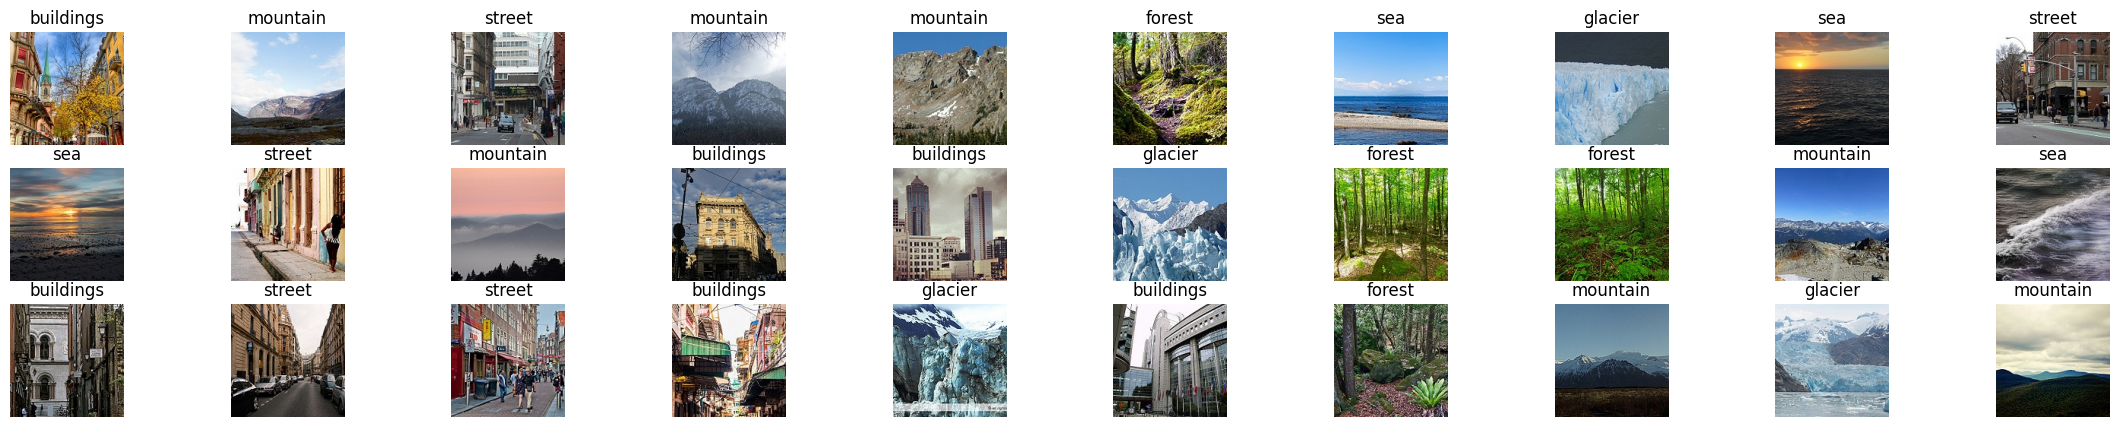

In [29]:
plt.figure(figsize=(28, 5), dpi=100)

for idx in range(30):
    img = Image.open(validation_imagenames[idx])
    plt.subplot(3, 10, idx+1)
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(CLASSES[predictions[idx]])

In [30]:
pt.save(model, "./v2.0-intel-image-classification-pytorch.pt")